In [2]:
# creating models per key word 

from pytrends.request import TrendReq
from prophet import Prophet
from prophet.serialize import model_to_json
import pandas as pd
import os
import time

keywords = ['flu', 'cough', 'fever', 'cold', 'symptoms']

pytrends = TrendReq(hl='en-US', tz=360)

os.makedirs('models', exist_ok=True)

for kw in keywords:
    print(f"Training model for keyword: {kw}")

    try:
        pytrends.build_payload([kw], timeframe='today 5-y')
        df = pytrends.interest_over_time().reset_index().drop(columns=['isPartial'])

        if df.empty:
            print(f"No data for {kw}, skipping...")
            continue

        df = df.rename(columns={"date": "ds", kw: "y"})

        model = Prophet()
        model.fit(df)

        # Save the model
        model_filename = f'models/prophet_{kw}.json'
        with open(model_filename, 'w') as fout:
            fout.write(model_to_json(model))

        print(f"Saved model for '{kw}' at {model_filename}")

    except Exception as e:
        print(f"Error training model for '{kw}': {e}")

    time.sleep(10)

print("All keywords processed.")


🚀 Training model for keyword: flu


00:45:31 - cmdstanpy - INFO - Chain [1] start processing
00:45:31 - cmdstanpy - INFO - Chain [1] done processing


✅ Saved model for 'flu' at models/prophet_flu.json
🚀 Training model for keyword: cough


00:45:42 - cmdstanpy - INFO - Chain [1] start processing
00:45:42 - cmdstanpy - INFO - Chain [1] done processing


✅ Saved model for 'cough' at models/prophet_cough.json
🚀 Training model for keyword: fever


00:45:52 - cmdstanpy - INFO - Chain [1] start processing
00:45:53 - cmdstanpy - INFO - Chain [1] done processing


✅ Saved model for 'fever' at models/prophet_fever.json
🚀 Training model for keyword: cold


00:46:03 - cmdstanpy - INFO - Chain [1] start processing
00:46:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Saved model for 'cold' at models/prophet_cold.json
🚀 Training model for keyword: symptoms


00:46:14 - cmdstanpy - INFO - Chain [1] start processing
00:46:14 - cmdstanpy - INFO - Chain [1] done processing


✅ Saved model for 'symptoms' at models/prophet_symptoms.json
🏁 All keywords processed.



🚀 Training model and evaluating for keyword: flu
❌ Error processing 'flu': The request failed: Google returned a response with code 429

🚀 Training model and evaluating for keyword: cough


21:03:27 - cmdstanpy - INFO - Chain [1] start processing
21:03:27 - cmdstanpy - INFO - Chain [1] done processing


📊 Range-based Accuracy: 76.63%
📊 MAPE Accuracy: 87.98%
📊 SMAPE Accuracy: 86.80%
✅ Saved model for 'cough' at models/prophet_cough.json


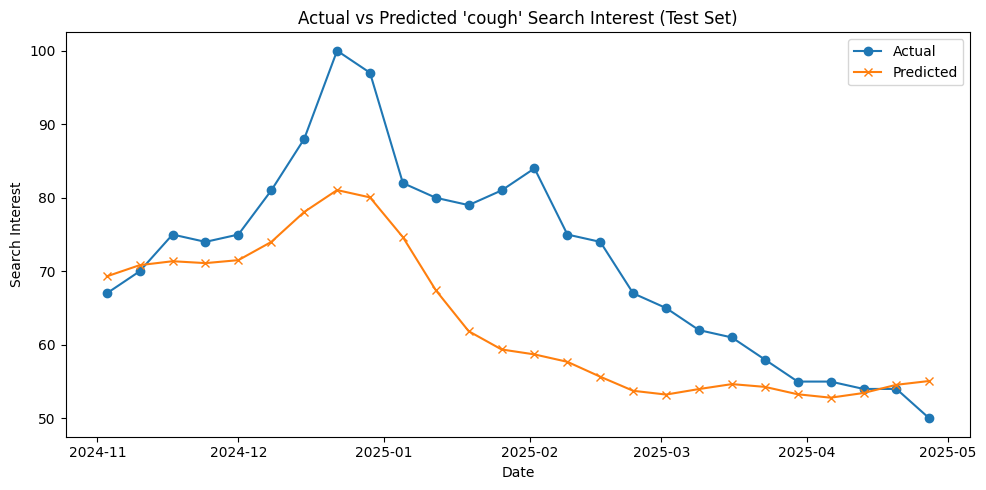

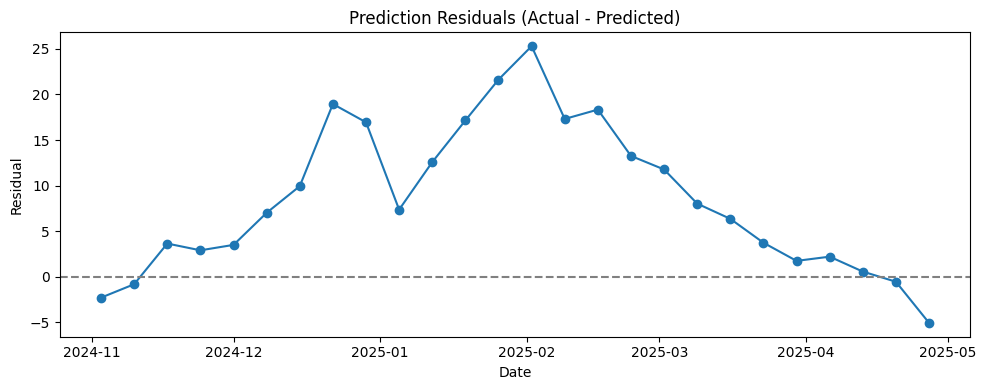


🚀 Training model and evaluating for keyword: fever


21:03:40 - cmdstanpy - INFO - Chain [1] start processing
21:03:40 - cmdstanpy - INFO - Chain [1] done processing


📊 Range-based Accuracy: 43.73%
📊 MAPE Accuracy: 81.30%
📊 SMAPE Accuracy: 83.10%
✅ Saved model for 'fever' at models/prophet_fever.json


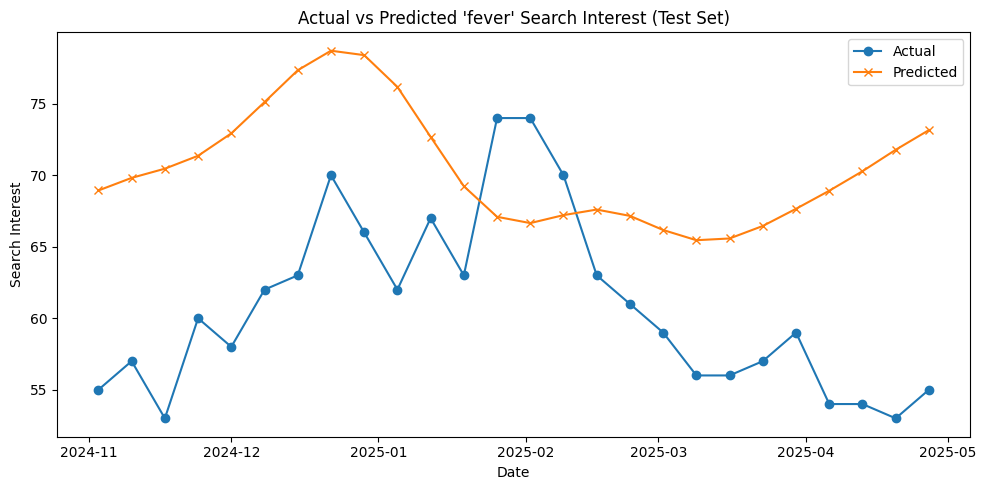

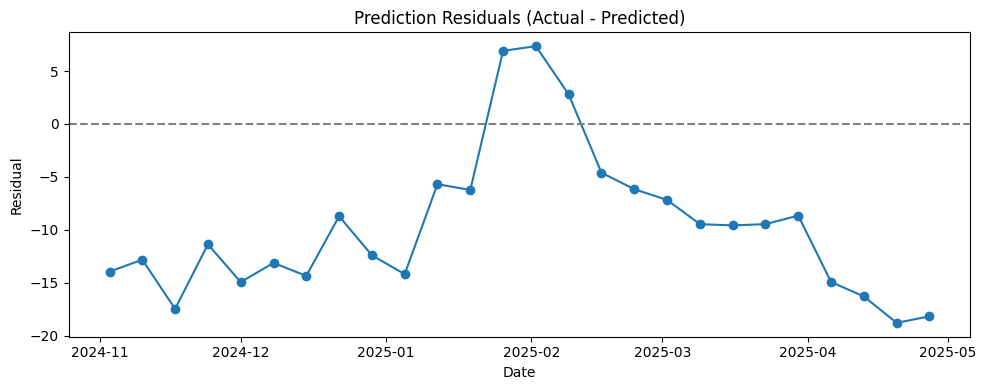


🚀 Training model and evaluating for keyword: cold


21:03:51 - cmdstanpy - INFO - Chain [1] start processing
21:03:51 - cmdstanpy - INFO - Chain [1] done processing


📊 Range-based Accuracy: 79.77%
📊 MAPE Accuracy: 92.99%
📊 SMAPE Accuracy: 92.53%
✅ Saved model for 'cold' at models/prophet_cold.json


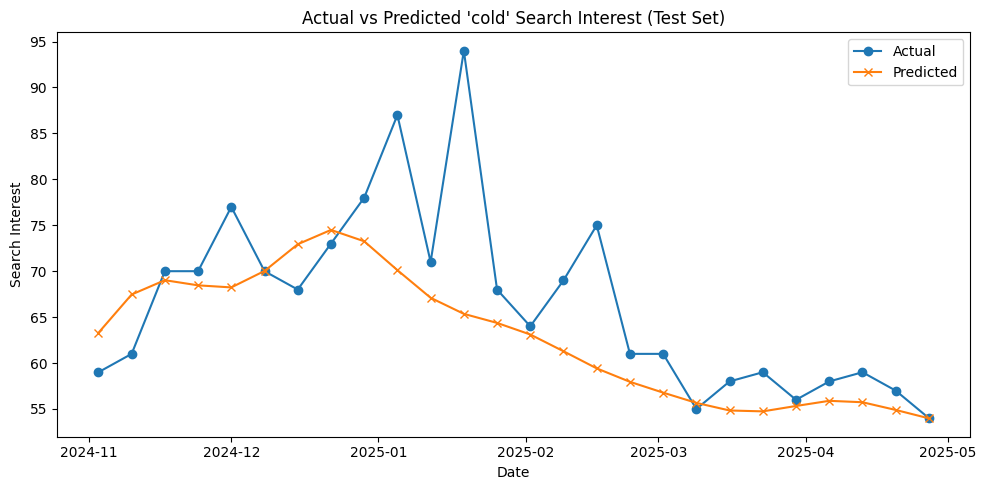

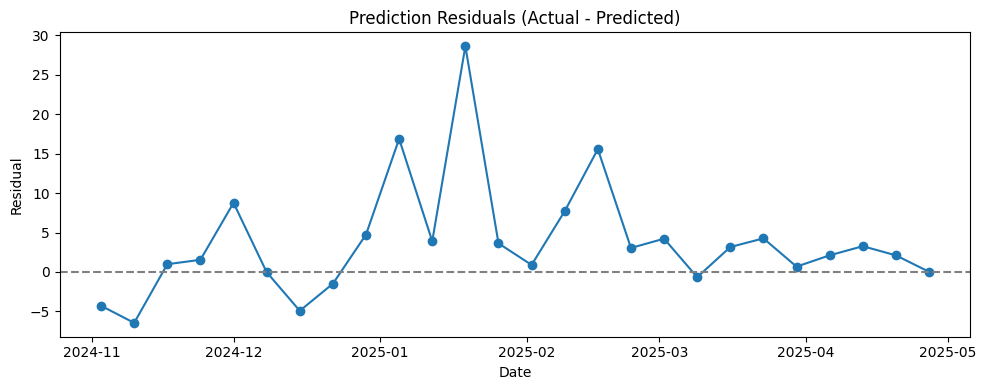


🚀 Training model and evaluating for keyword: symptoms


21:04:03 - cmdstanpy - INFO - Chain [1] start processing
21:04:03 - cmdstanpy - INFO - Chain [1] done processing


📊 Range-based Accuracy: 54.44%
📊 MAPE Accuracy: 93.69%
📊 SMAPE Accuracy: 93.54%
✅ Saved model for 'symptoms' at models/prophet_symptoms.json


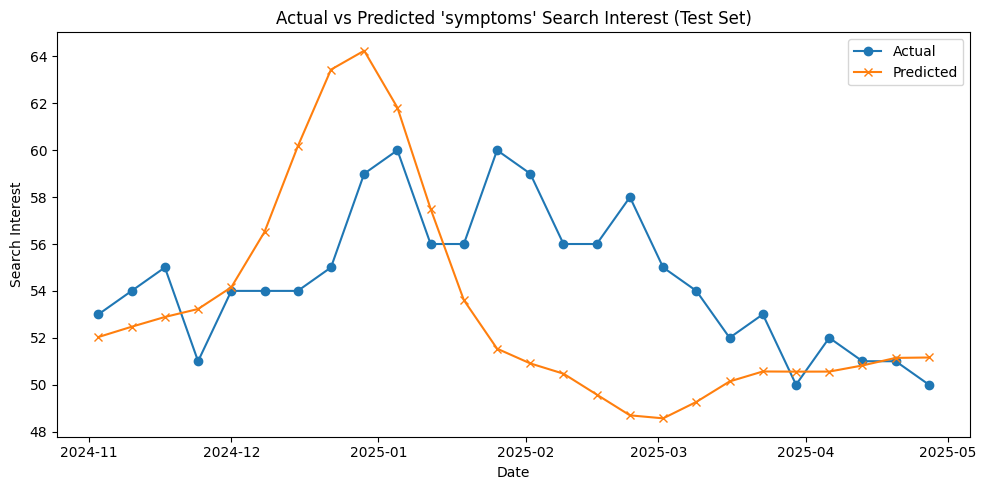

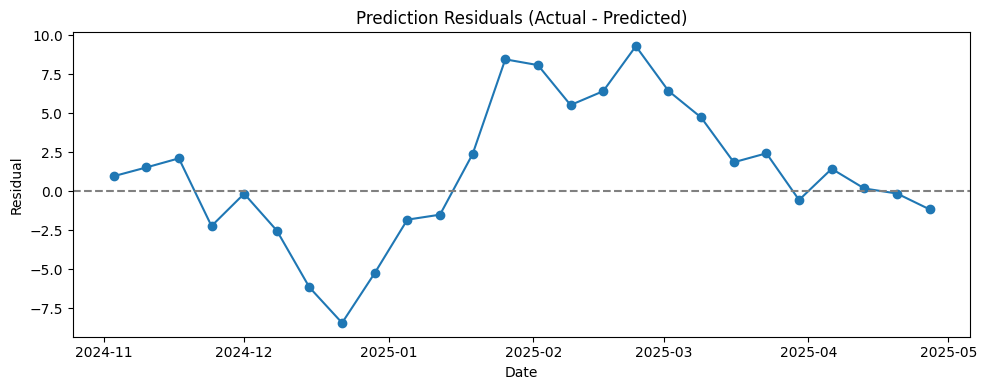


🏁 All keywords processed.


In [6]:
from pytrends.request import TrendReq
from prophet import Prophet
from prophet.serialize import model_to_json
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

keywords = ['flu', 'cough', 'fever', 'cold', 'symptoms']

pytrends = TrendReq(hl='en-US', tz=360)

os.makedirs('models_remove', exist_ok=True)

for kw in keywords:
    print(f"\n Training model and evaluating for keyword: {kw}")

    try:
        pytrends.build_payload([kw], timeframe='today 5-y')
        df = pytrends.interest_over_time().reset_index().drop(columns=['isPartial'])

        if df.empty:
            print(f"No data for {kw}, skipping...")
            continue

        df = df.rename(columns={"date": "ds", kw: "y"})

        train = df.iloc[:-26]
        test = df.iloc[-26:]

        model = Prophet()
        model.fit(train)

        future = model.make_future_dataframe(periods=len(test), freq='W')  # Weekly data
        forecast = model.predict(future)

        forecast_trimmed = forecast[['ds', 'yhat']].set_index('ds')
        test_trimmed = test.set_index('ds')

        merged = test_trimmed.join(forecast_trimmed, how='left').dropna()

        y_true = merged['y'].values
        y_pred = merged['yhat'].values

        # RMSE
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        target_range = y_true.max() - y_true.min()
        accuracy_range = (1 - rmse / target_range) * 100

        # MAPE
        epsilon = 1e-10
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
        mape_accuracy = 100 - mape

        # SMAPE
        smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
        smape_accuracy = 100 - smape

        print(f"Range-based Accuracy: {accuracy_range:.2f}%")
        print(f"MAPE Accuracy: {mape_accuracy:.2f}%")
        print(f"SMAPE Accuracy: {smape_accuracy:.2f}%")

        model_filename = f'models/prophet_{kw}.json'
        with open(model_filename, 'w') as fout:
            fout.write(model_to_json(model))

        print(f"Saved model for '{kw}' at {model_filename}")

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(merged.index, merged['y'], label='Actual', marker='o')
        plt.plot(merged.index, merged['yhat'], label='Predicted', marker='x')
        plt.title(f"Actual vs Predicted '{kw}' Search Interest (Test Set)")
        plt.xlabel("Date")
        plt.ylabel("Search Interest")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Residuals plot
        residuals = merged['y'] - merged['yhat']
        plt.figure(figsize=(10, 4))
        plt.plot(merged.index, residuals, marker='o')
        plt.axhline(0, color='gray', linestyle='--')
        plt.title("Prediction Residuals (Actual - Predicted)")
        plt.xlabel("Date")
        plt.ylabel("Residual")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing '{kw}': {e}")

    time.sleep(10)

print("\n All keywords processed.")
